## Семинар 8: "Снижение размерности"

ФИО: Лысухин Даниил

In [1]:
import numpy as np
from sklearn.utils import shuffle
from sklearn.datasets import fetch_olivetti_faces
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
%matplotlib inline

/home/lysuhin/Distr/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Этот семинар посвящен сниению размерности на примере данных Olivetti faces. В данных содержатся 400 черно-белых изображений 64x64. Требуется исследовать различные способы снижения размерности: PCA и Автокодировщик

In [2]:
X = fetch_olivetti_faces()['data']

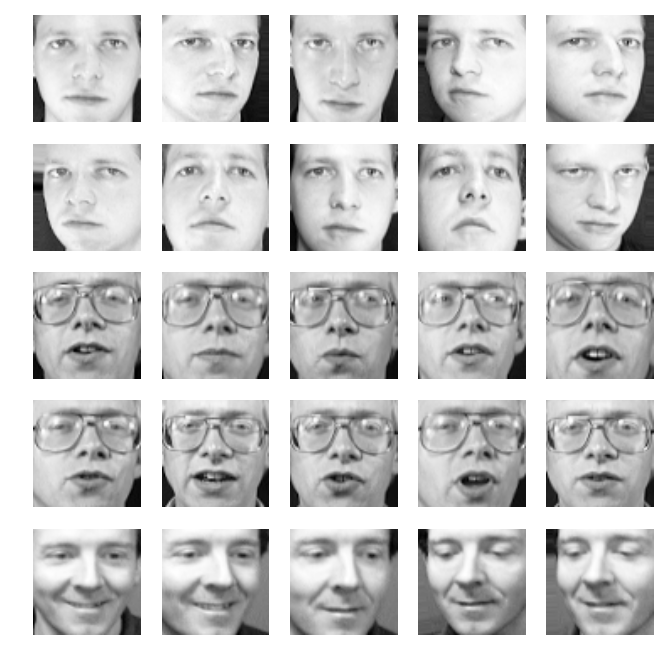

In [3]:
plt.figure(figsize=(8, 8))
for i in xrange(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(64, 64), cmap=plt.cm.Greys_r)
    plt.axis('off')
plt.show()

### Часть 1: PCA

In [25]:
from sklearn.decomposition import PCA

<i> 1.1 Примените алгоритм PCA к данным и отобразите главные компоненты. В качестве числа компонент выберите 25</i>

In [26]:
pca = PCA(n_components=25)

In [27]:
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=25, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [28]:
components = pca.components_
components.shape

(25, 4096)

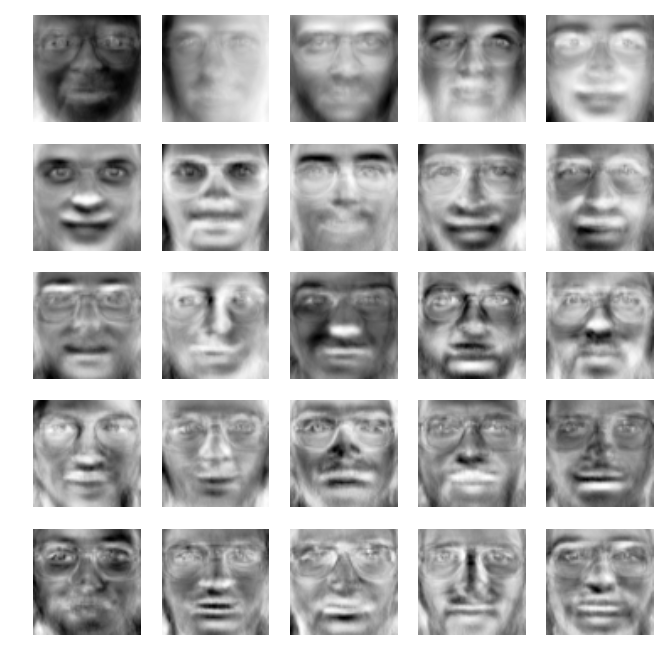

In [29]:
plt.figure(figsize=(8, 8))
for i in xrange(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(components[i].reshape(64, 64), cmap=plt.cm.Greys_r)
    plt.axis('off')
plt.show()

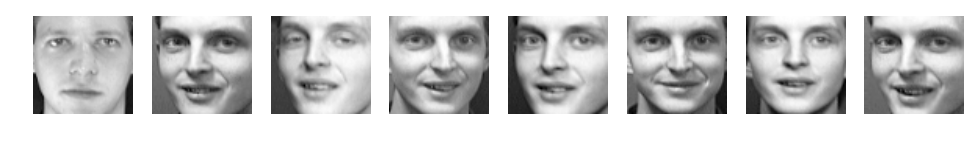

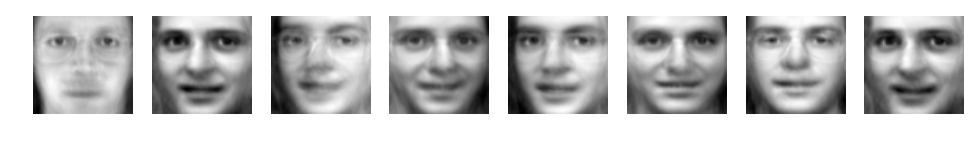

In [30]:
plt.figure(figsize=(12, 8))
for i in xrange(8):
    plt.subplot(1, 8, i+1)
    plt.imshow(X[-i].reshape(64, 64), cmap='gray')
    plt.axis('off')
plt.show()

plt.figure(figsize=(12, 8))
for i in xrange(8):
    plt.subplot(1, 8, i+1)
    plt.imshow(pca.inverse_transform(pca.transform(X[-i].reshape((1,-1)))).reshape(64, 64), cmap='gray')
    plt.axis('off')
plt.show()

<i> 1.2 Отобразите зависимость качества восстановления от количества компонент</i>
Подсказка: используйте методы <b>.transform</b> и <b>.inverse_transform</b>

In [31]:
import tqdm

In [32]:
n_components_range = range(0, 401, 5)

In [33]:
errors = []
for n_components in tqdm.tqdm_notebook(n_components_range):
    pca = PCA(n_components=n_components)
    pca.fit(X)
    error = np.linalg.norm(X - pca.inverse_transform(pca.transform(X)))
    errors.append(error)

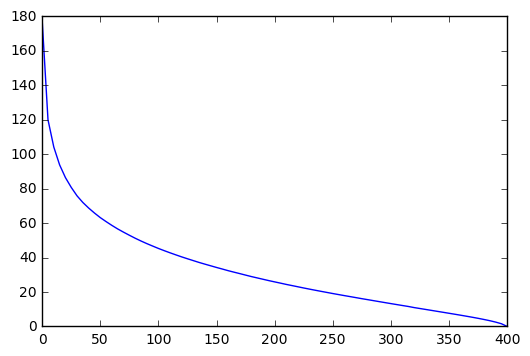

In [34]:
plt.plot(n_components_range, errors)

<i>1.3 Какое количество компонент следует выбирать, чтобы соблюсти баланс размерность — качество?</i>

<i>1.4 Отобразите данные на плоскости (количество компонент = 2). Выделились ли какие-нибудь кластеры? Если да, чему они соответствуют?</i>

In [19]:
pca_2comp = PCA(n_components=2)
pca_2comp.fit(X)
X_2d = pca_2comp.transform(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [21]:
X_2d.shape

(400, 2)

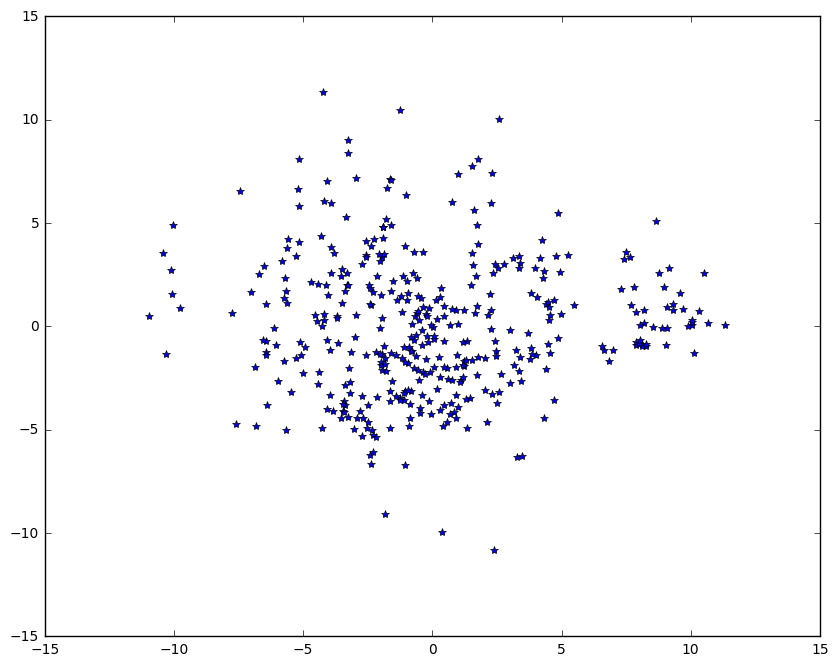

In [30]:
plt.figure(figsize=(10, 8))
plt.plot(X_2d[:, 0], X_2d[:, 1], "*")

In [38]:
def plot_dataset(dataset, x, y, margin=50, frame=2000., imsize=64):
    x1 = (x - x.min()) * (frame / (x.max() - x.min())) + margin
    y1 = (y - y.min()) * (frame / (y.max() - y.min())) + margin
    image = np.zeros((int(y1.max() + margin + imsize), int(x1.max() + margin + imsize))) + 1
    print "Image size is %dx%d" % image.shape
    for k in xrange(dataset.shape[0]):
        image[int(y1[k]): int(y1[k]) + 64, int(x1[k]): int(x1[k]) + 64] = dataset[k]
    plt.figure(figsize=(20, 20))
    plt.imshow(image, cmap="Greys_r")
    plt.axis("off")
    plt.show()

Image size is 2164x2164


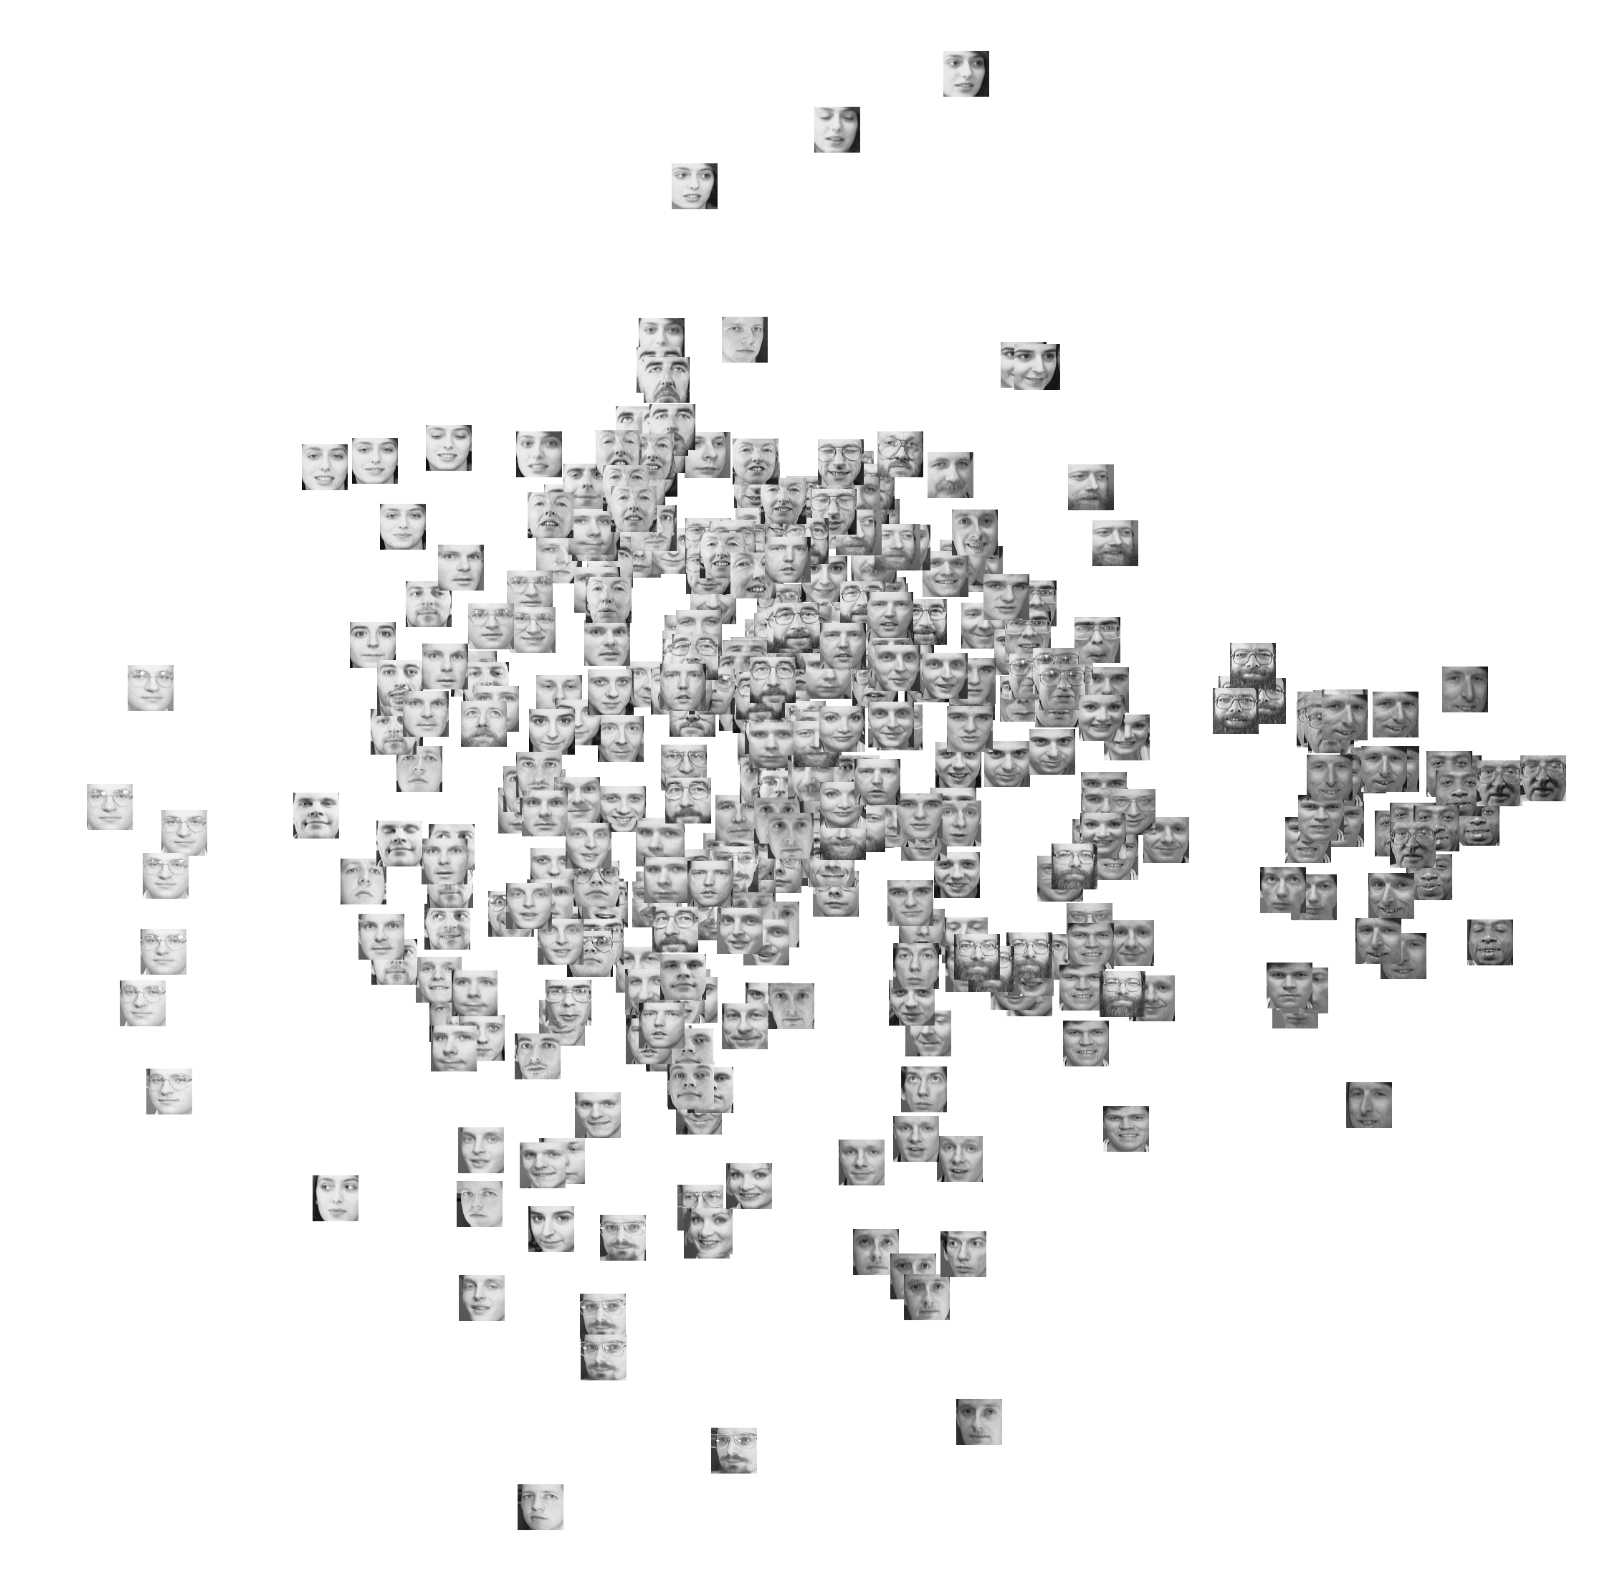

In [78]:
plot_dataset(X.reshape((400, 64, 64)), X_2d[:, 0], X_2d[:, 1])

In [18]:
X_centered = (X - X.mean(axis=0)) / X.std(axis=0)
X_centered.shape

(400, 4096)

In [306]:
pca_2comp = PCA(n_components=2)
pca_2comp.fit(X_centered)
X_2d_centered = pca_2comp.transform(X_centered)

Image size is 2164x2164


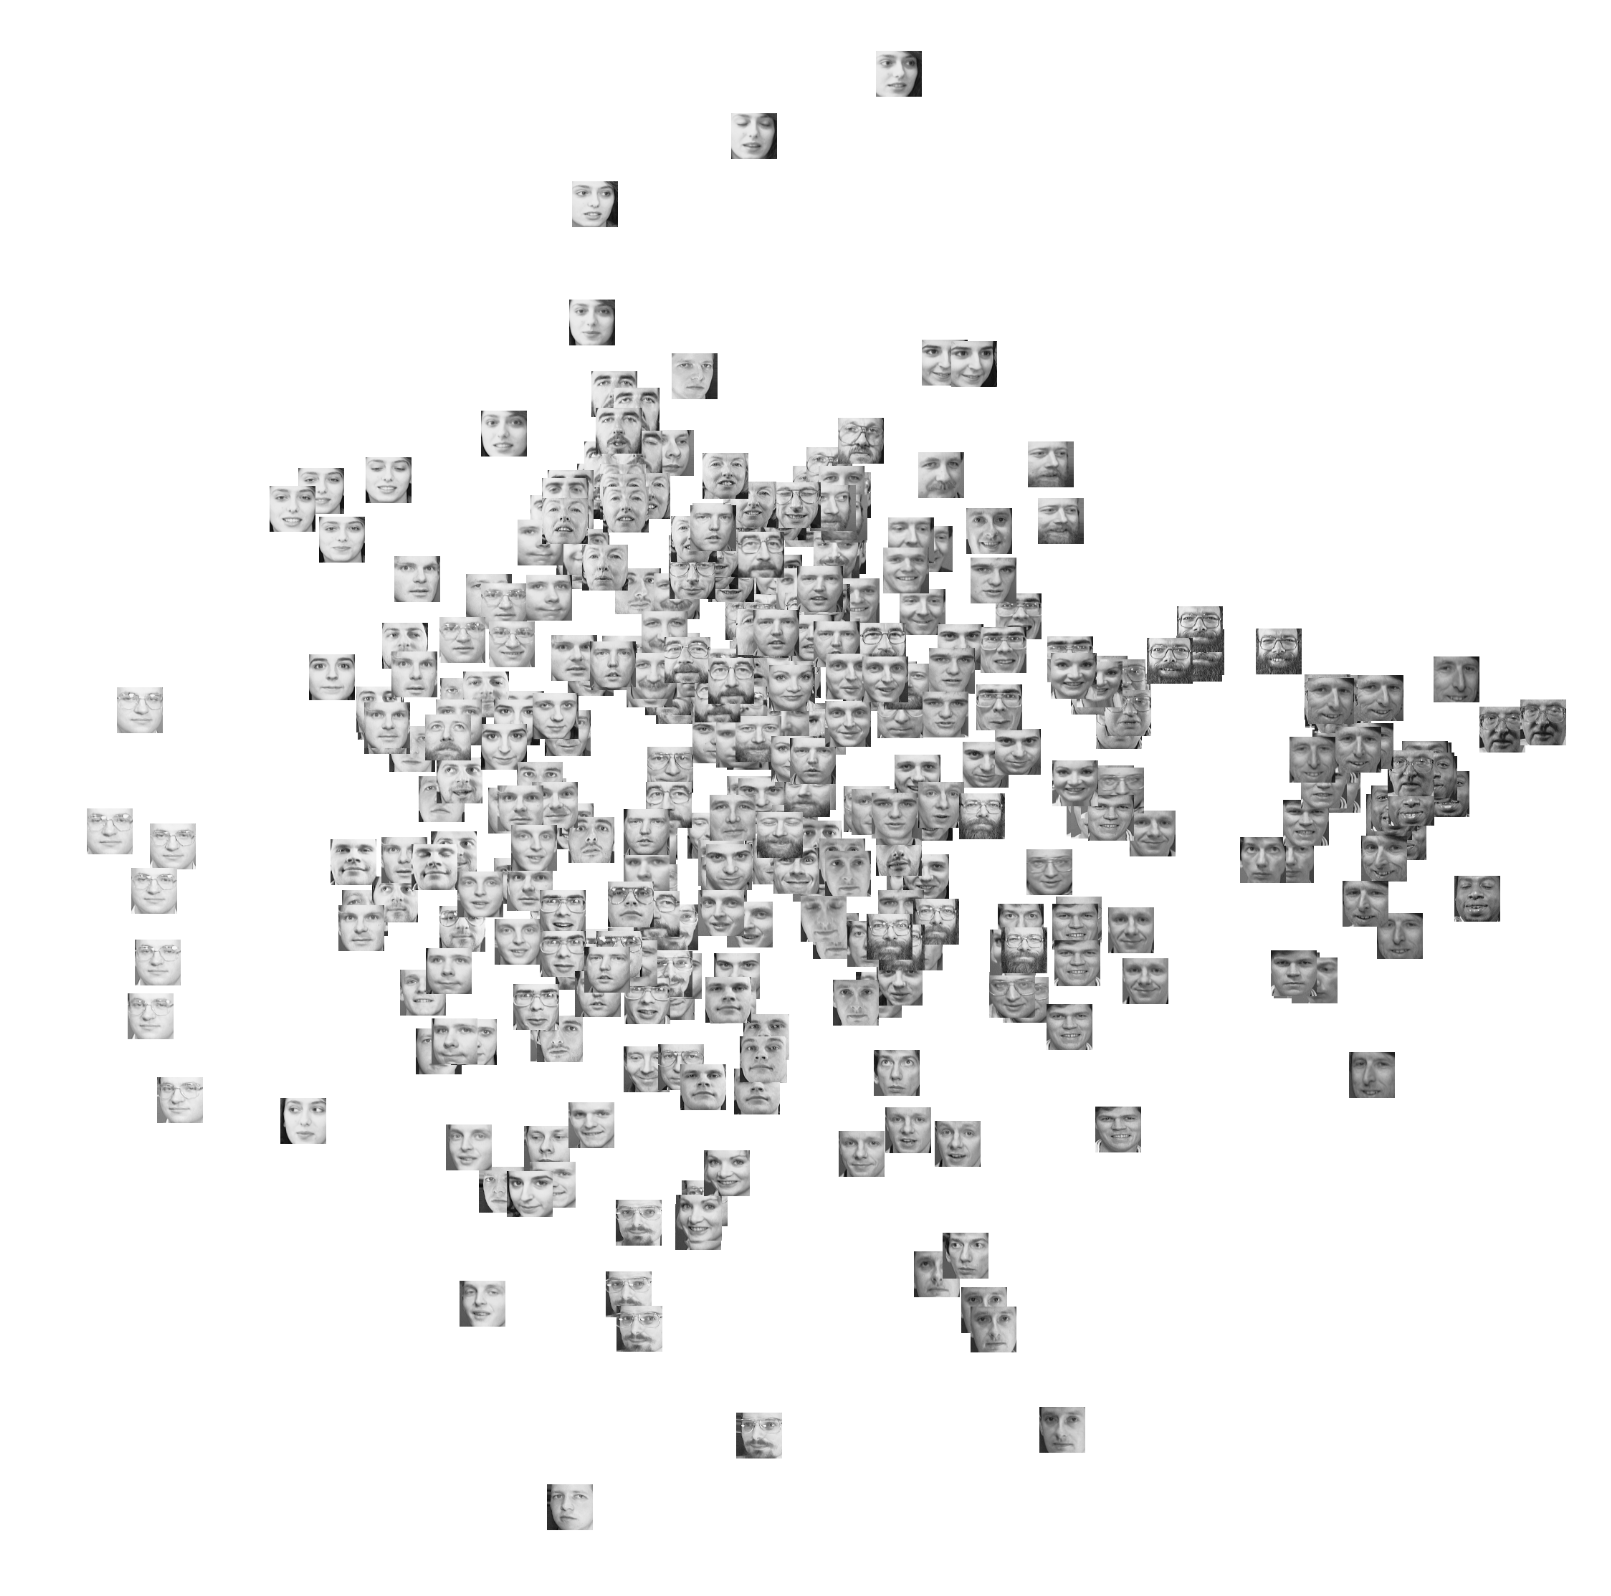

In [307]:
plot_dataset(X.reshape((400, 64, 64)), X_2d_centered[:, 0], X_2d_centered[:, 1])

###  Часть 2: Автокодировщик

<i> 2.1 Обучите автокодировщик с архитектурой 4096 -> 200 -> 10 -> 200 -> 4096. В качестве нелинейностей используйте сигмоиду.</i>

In [10]:
class MyAutoEncoder(nn.Module):
    def __init__(self, dim=10):
        super(MyAutoEncoder, self).__init__()
        self.encoding_layers = nn.Sequential(nn.Linear(64 * 64, 200),
                                             nn.Sigmoid(),
                                             nn.Linear(200, dim), 
                                             nn.Sigmoid())
        
        self.decoding_layers = nn.Sequential(nn.Linear(dim, 200),
                                             nn.Sigmoid(),
                                             nn.Linear(200, 64 * 64),
                                             nn.Sigmoid())
        
    def forward(self, x):
        x = self.encoding_layers(x)
        x = self.decoding_layers(x)
        return x
    
    def encode(self, x):
        return self.encoding_layers(x)
    
    def decode(self, x):
        return self.decoding_layers(x)

In [11]:
def MSE(input, target):
    return torch.norm(input-target)

In [14]:
def train_autoencoder(autoencoder, X, n_epochs=40, batch_size=10, lr=1e-3, each=10):

    dtype = torch.FloatTensor

#     loss_fn = torch.nn.MSELoss()
    loss_fn = MSE
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr, weight_decay=1e-5)
        
    n_batches = X.shape[0] / batch_size
    loss_on_epochs = []
    
    for epoch in tqdm.tqdm_notebook(xrange(n_epochs), leave="False"):
        X = shuffle(X)
        losses=[]
        for batch in xrange(n_batches):
            x = Variable(torch.from_numpy(X[batch * batch_size: (batch + 1) * batch_size]).type(dtype), requires_grad = False)
            x_restored = autoencoder.forward(x)

            loss = loss_fn(input = x_restored, target = x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            losses.append(loss.data[0])
            
        loss_on_epochs.append(np.mean(losses))
        if epoch % each == 0:
            print ("epoch #%d, train loss %.4f" % (epoch, loss_on_epochs[-1]))
        
    return autoencoder, loss_on_epochs

In [332]:
# ae = MyAutoEncoder(dim=10)
ae, loss = train_autoencoder(ae, X_centered, n_epochs=200)

epoch #0, train loss 183.3161
epoch #10, train loss 183.0657
epoch #20, train loss 182.4863
epoch #30, train loss 182.3758
epoch #40, train loss 182.1971
epoch #50, train loss 182.0513
epoch #60, train loss 181.6518
epoch #70, train loss 181.5829
epoch #80, train loss 181.4805
epoch #90, train loss 181.0621
epoch #100, train loss 180.8933
epoch #110, train loss 180.5403
epoch #120, train loss 180.1568
epoch #130, train loss 180.0461
epoch #140, train loss 179.6723
epoch #150, train loss 179.3080
epoch #160, train loss 179.1122
epoch #170, train loss 178.9154
epoch #180, train loss 178.5226
epoch #190, train loss 178.4490



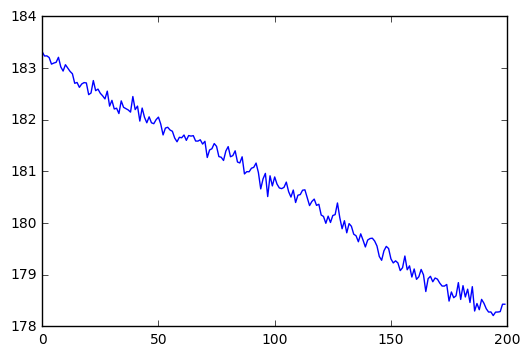

In [333]:
plt.plot(loss)

In [334]:
X_restored_centered = ae.decode(ae.encode(Variable(torch.from_numpy(X_centered.reshape(400, 4096)).type(torch.FloatTensor), requires_grad=False, volatile=True))).data.numpy()
X_restored = X_restored_centered * X.std(axis=0) + X.mean(axis=0)

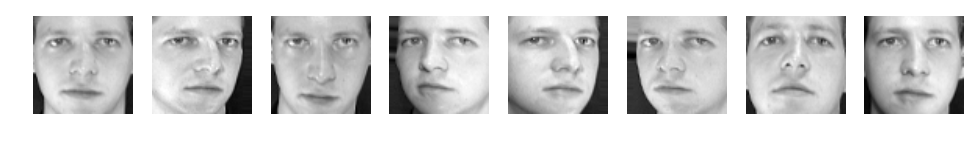

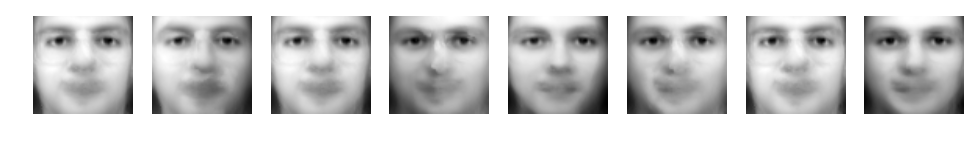

In [336]:
plt.figure(figsize=(12, 8))
for i in xrange(8):
    plt.subplot(1, 8, i+1)
    plt.imshow(X[i].reshape(64, 64), cmap='gray')
    plt.axis('off')
plt.show()

plt.figure(figsize=(12, 8))
for i in xrange(8):
    plt.subplot(1, 8, i+1)
    plt.imshow(X_restored[i].reshape(64, 64), cmap='gray')
    plt.axis('off')
plt.show()

<i> 2.2 Какое качество восстановления удалось получить?</i>

<i> 2.3 Обучите сеть с разными размерностями пространства, в которое происходит отображение </i>

In [13]:
n_components_log_range = np.logspace(3, 8, num=6, base=2.)
n_components_log_range = [int(j) for j in n_components_log_range]
n_components_log_range

[8, 16, 32, 64, 128, 256]

n_components: 8
epoch #0, train loss 208.0005
epoch #10, train loss 193.0870
epoch #20, train loss 190.6772
epoch #30, train loss 185.1026
epoch #40, train loss 182.7922
epoch #50, train loss 180.7354
epoch #60, train loss 178.6523
epoch #70, train loss 178.2121
epoch #80, train loss 177.9090
epoch #90, train loss 177.6408
epoch #100, train loss 177.3478
epoch #110, train loss 177.0523
epoch #120, train loss 176.4562
epoch #130, train loss 175.9077
epoch #140, train loss 175.0389
epoch #150, train loss 174.2558
epoch #160, train loss 173.7918
epoch #170, train loss 173.5357
epoch #180, train loss 172.9508
epoch #190, train loss 172.9904
epoch #200, train loss 172.7134
epoch #210, train loss 172.3405
epoch #220, train loss 172.2296
epoch #230, train loss 172.0388
epoch #240, train loss 171.6614
epoch #250, train loss 171.8000
epoch #260, train loss 171.1723
epoch #270, train loss 171.3628
epoch #280, train loss 170.7399
epoch #290, train loss 170.4288
epoch #300, train loss 170.7169
epo

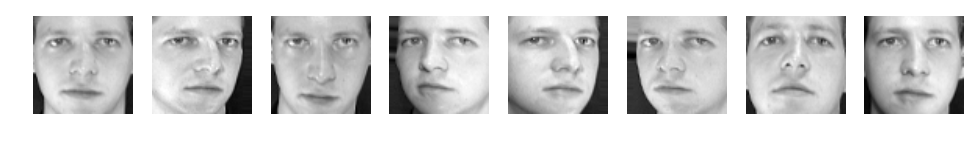

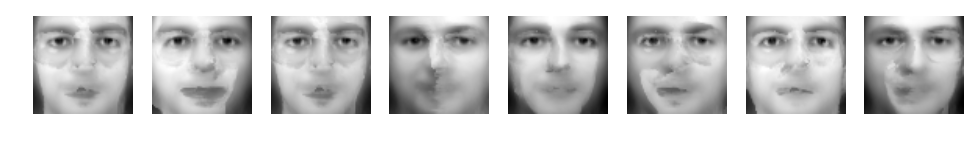

n_components: 16
epoch #0, train loss 207.6938
epoch #10, train loss 192.5115
epoch #20, train loss 185.2425
epoch #30, train loss 182.4619
epoch #40, train loss 180.3875
epoch #50, train loss 178.5880
epoch #60, train loss 177.8141
epoch #70, train loss 176.7915
epoch #80, train loss 176.0946
epoch #90, train loss 175.0941
epoch #100, train loss 174.3616
epoch #110, train loss 173.3650
epoch #120, train loss 172.8954
epoch #130, train loss 172.3065
epoch #140, train loss 171.6806
epoch #150, train loss 171.1366
epoch #160, train loss 170.5276
epoch #170, train loss 169.9557
epoch #180, train loss 169.6800
epoch #190, train loss 169.1827
epoch #200, train loss 168.7827
epoch #210, train loss 168.5339
epoch #220, train loss 168.0508
epoch #230, train loss 167.7015
epoch #240, train loss 167.5299
epoch #250, train loss 167.2797
epoch #260, train loss 166.7657
epoch #270, train loss 166.6787
epoch #280, train loss 166.1622
epoch #290, train loss 166.2024
epoch #300, train loss 165.8381
ep

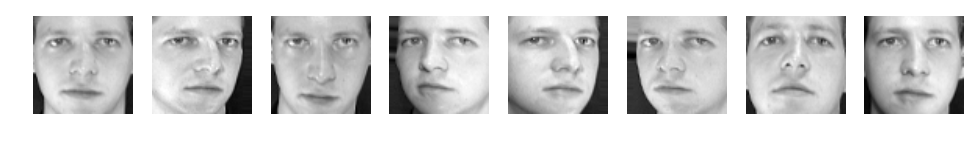

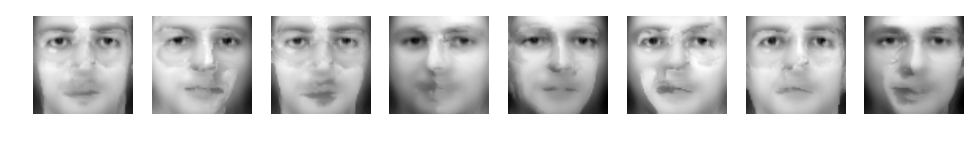

n_components: 32
epoch #0, train loss 208.0546
epoch #10, train loss 192.4806
epoch #20, train loss 185.1809
epoch #30, train loss 182.1257
epoch #40, train loss 178.9670
epoch #50, train loss 177.6432
epoch #60, train loss 177.3130
epoch #70, train loss 175.7318
epoch #80, train loss 174.6667
epoch #90, train loss 173.2205
epoch #100, train loss 172.3015
epoch #110, train loss 171.3028
epoch #120, train loss 170.4560
epoch #130, train loss 169.8958
epoch #140, train loss 169.1841
epoch #150, train loss 168.6748
epoch #160, train loss 168.0230
epoch #170, train loss 167.3893
epoch #180, train loss 166.9857
epoch #190, train loss 166.6522
epoch #200, train loss 166.2401
epoch #210, train loss 165.8223
epoch #220, train loss 165.2214
epoch #230, train loss 164.9215
epoch #240, train loss 164.5306
epoch #250, train loss 164.5499
epoch #260, train loss 164.0472
epoch #270, train loss 163.7096
epoch #280, train loss 163.5558
epoch #290, train loss 163.2528
epoch #300, train loss 162.6142
ep

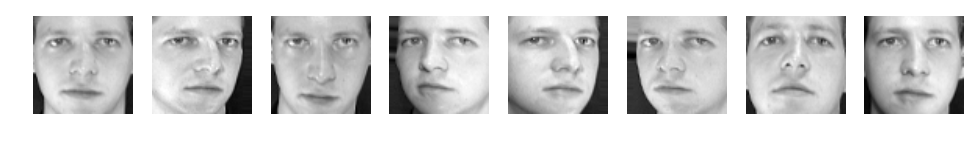

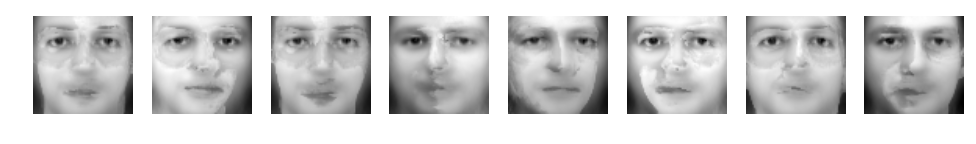

n_components: 64
epoch #0, train loss 207.1822
epoch #10, train loss 192.6834
epoch #20, train loss 183.9997
epoch #30, train loss 179.5121
epoch #40, train loss 177.6621
epoch #50, train loss 175.7214
epoch #60, train loss 174.2673
epoch #70, train loss 172.9939
epoch #80, train loss 171.6080
epoch #90, train loss 170.4055
epoch #100, train loss 169.5305
epoch #110, train loss 168.3664
epoch #120, train loss 167.6660
epoch #130, train loss 167.1710
epoch #140, train loss 166.4978
epoch #150, train loss 166.1035
epoch #160, train loss 165.4475
epoch #170, train loss 164.6992
epoch #180, train loss 164.6593
epoch #190, train loss 164.1937
epoch #200, train loss 163.7502
epoch #210, train loss 163.4629
epoch #220, train loss 163.1026
epoch #230, train loss 162.6680
epoch #240, train loss 162.4863
epoch #250, train loss 162.3204
epoch #260, train loss 161.8009
epoch #270, train loss 162.0384
epoch #280, train loss 161.7130
epoch #290, train loss 161.4121
epoch #300, train loss 161.0146
ep

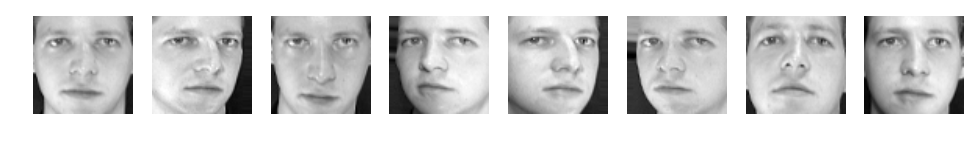

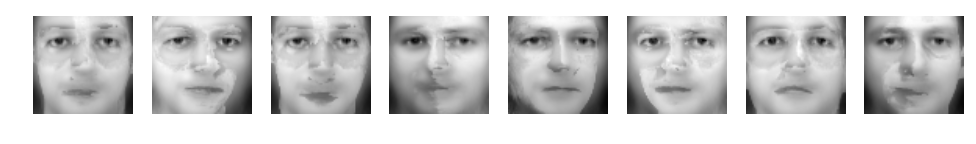

n_components: 128
epoch #0, train loss 206.3340
epoch #10, train loss 190.7751
epoch #20, train loss 181.6615
epoch #30, train loss 177.9047
epoch #40, train loss 175.0664
epoch #50, train loss 173.6205
epoch #60, train loss 171.9769
epoch #70, train loss 170.6964
epoch #80, train loss 169.4480
epoch #90, train loss 168.4314
epoch #100, train loss 167.5016
epoch #110, train loss 166.4546
epoch #120, train loss 165.8386
epoch #130, train loss 165.4312
epoch #140, train loss 164.8819
epoch #150, train loss 163.9398
epoch #160, train loss 163.7243
epoch #170, train loss 163.6655
epoch #180, train loss 163.1329
epoch #190, train loss 162.6700
epoch #200, train loss 162.4406
epoch #210, train loss 162.1336
epoch #220, train loss 161.7458
epoch #230, train loss 161.5902
epoch #240, train loss 161.4980
epoch #250, train loss 160.9074
epoch #260, train loss 160.9302
epoch #270, train loss 160.9776
epoch #280, train loss 160.4724
epoch #290, train loss 160.2094
epoch #300, train loss 160.1008
e

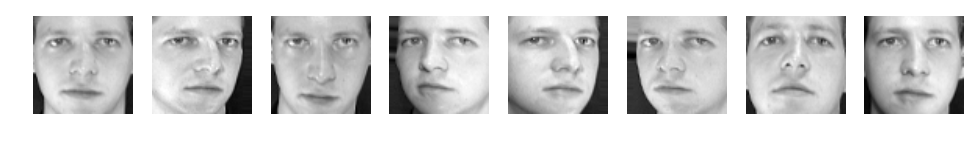

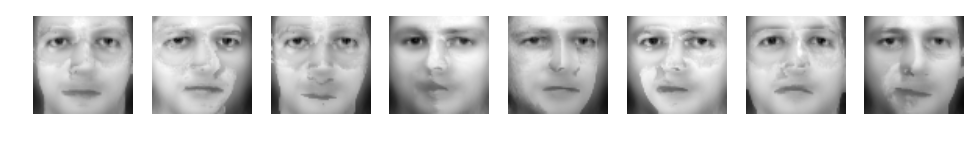

n_components: 256
epoch #0, train loss 205.4174
epoch #10, train loss 190.6698
epoch #20, train loss 180.5046
epoch #30, train loss 176.9182
epoch #40, train loss 174.0220
epoch #50, train loss 171.9632
epoch #60, train loss 170.1744
epoch #70, train loss 168.9066
epoch #80, train loss 167.7058
epoch #90, train loss 166.6808
epoch #100, train loss 165.4236
epoch #110, train loss 165.0927
epoch #120, train loss 164.4645
epoch #130, train loss 163.7901
epoch #140, train loss 163.3819
epoch #150, train loss 163.2183
epoch #160, train loss 162.6990
epoch #170, train loss 162.2938
epoch #180, train loss 162.0493
epoch #190, train loss 160.9988
epoch #200, train loss 160.9980
epoch #210, train loss 161.2045
epoch #220, train loss 160.9067
epoch #230, train loss 160.3458
epoch #240, train loss 160.8838
epoch #250, train loss 160.3111
epoch #260, train loss 160.2832
epoch #270, train loss 159.6026
epoch #280, train loss 159.4658
epoch #290, train loss 159.3100
epoch #300, train loss 159.4971
e

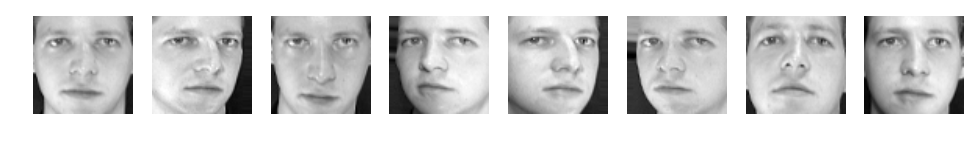

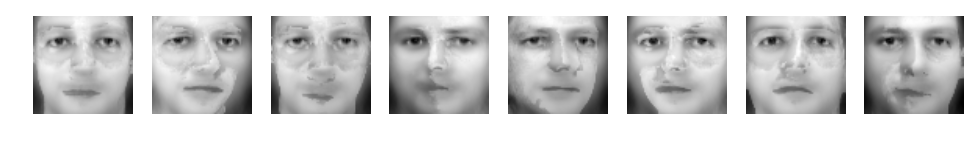

In [20]:
losses = []
for n_components in n_components_log_range:
    print "=" * 75
    print "n_components: %d" % n_components
    ae = MyAutoEncoder(dim=n_components)
    ae, loss = train_autoencoder(ae, X_centered, n_epochs=400)
    losses.append(loss[-1])

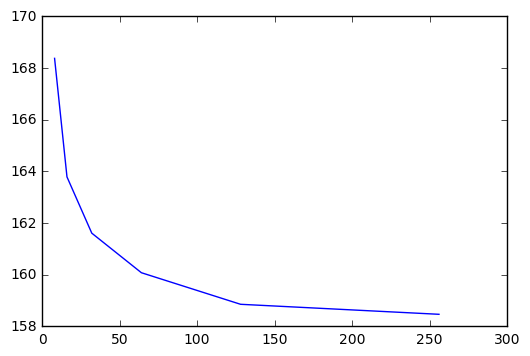

In [21]:
plt.plot(n_components_log_range, losses)

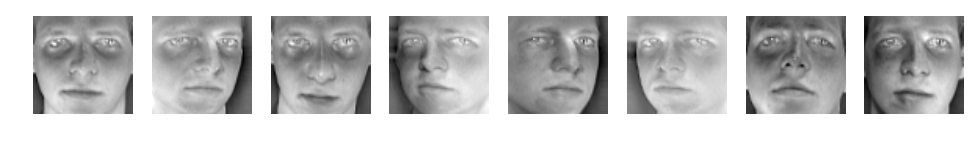

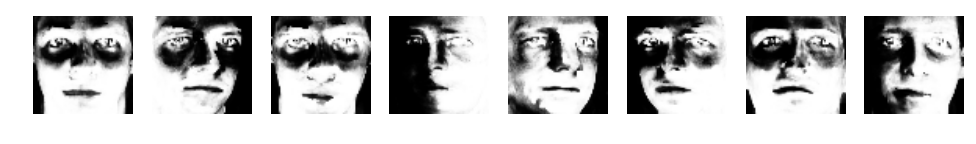

In [23]:
X_restored_centered = ae.decode(ae.encode(Variable(torch.from_numpy(X_centered.reshape(400, 4096)).type(torch.FloatTensor), requires_grad=False, volatile=True))).data.numpy()
    
plt.figure(figsize=(12, 8))
for i in xrange(8):
    plt.subplot(1, 8, i+1)
    plt.imshow(X_centered[i].reshape(64, 64), cmap='gray')
    plt.axis('off')
plt.show()

plt.figure(figsize=(12, 8))
for i in xrange(8):
    plt.subplot(1, 8, i+1)
    plt.imshow(X_restored_centered[i].reshape(64, 64), cmap='gray')
    plt.axis('off')
plt.show()

<i> 2.4 Сравните графики из пунктов 1.2 и 2.3 </i>

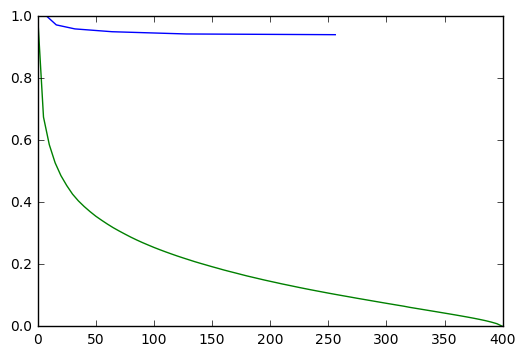

In [35]:
plt.plot(n_components_log_range, losses / max(losses))
plt.plot(range(0, 401, 5), errors / max(errors))

<i> 2.5 Отобразите данные на плоскости (количество компонент = 2). Выделились ли какие-нибудь кластеры? Если да, чему они соответствуют?</i>

In [42]:
ae = MyAutoEncoder(dim=2)
ae, losses = train_autoencoder(ae, X_centered, n_epochs=200, each=10)


epoch #0, train loss 208.3969
epoch #10, train loss 194.4788
epoch #20, train loss 190.9433
epoch #30, train loss 187.9100
epoch #40, train loss 184.2621
epoch #50, train loss 183.2514
epoch #60, train loss 182.8024
epoch #70, train loss 182.3313
epoch #80, train loss 182.2332
epoch #90, train loss 181.8387
epoch #100, train loss 181.6901
epoch #110, train loss 181.7577
epoch #120, train loss 181.4043
epoch #130, train loss 181.5525
epoch #140, train loss 181.3120
epoch #150, train loss 181.3178
epoch #160, train loss 180.8757
epoch #170, train loss 181.0753
epoch #180, train loss 180.5862
epoch #190, train loss 180.8475


In [43]:
X_2d = ae.encode(Variable(torch.from_numpy(X_centered).type(torch.FloatTensor), requires_grad=False, volatile=True))

Image size is 2164x2164


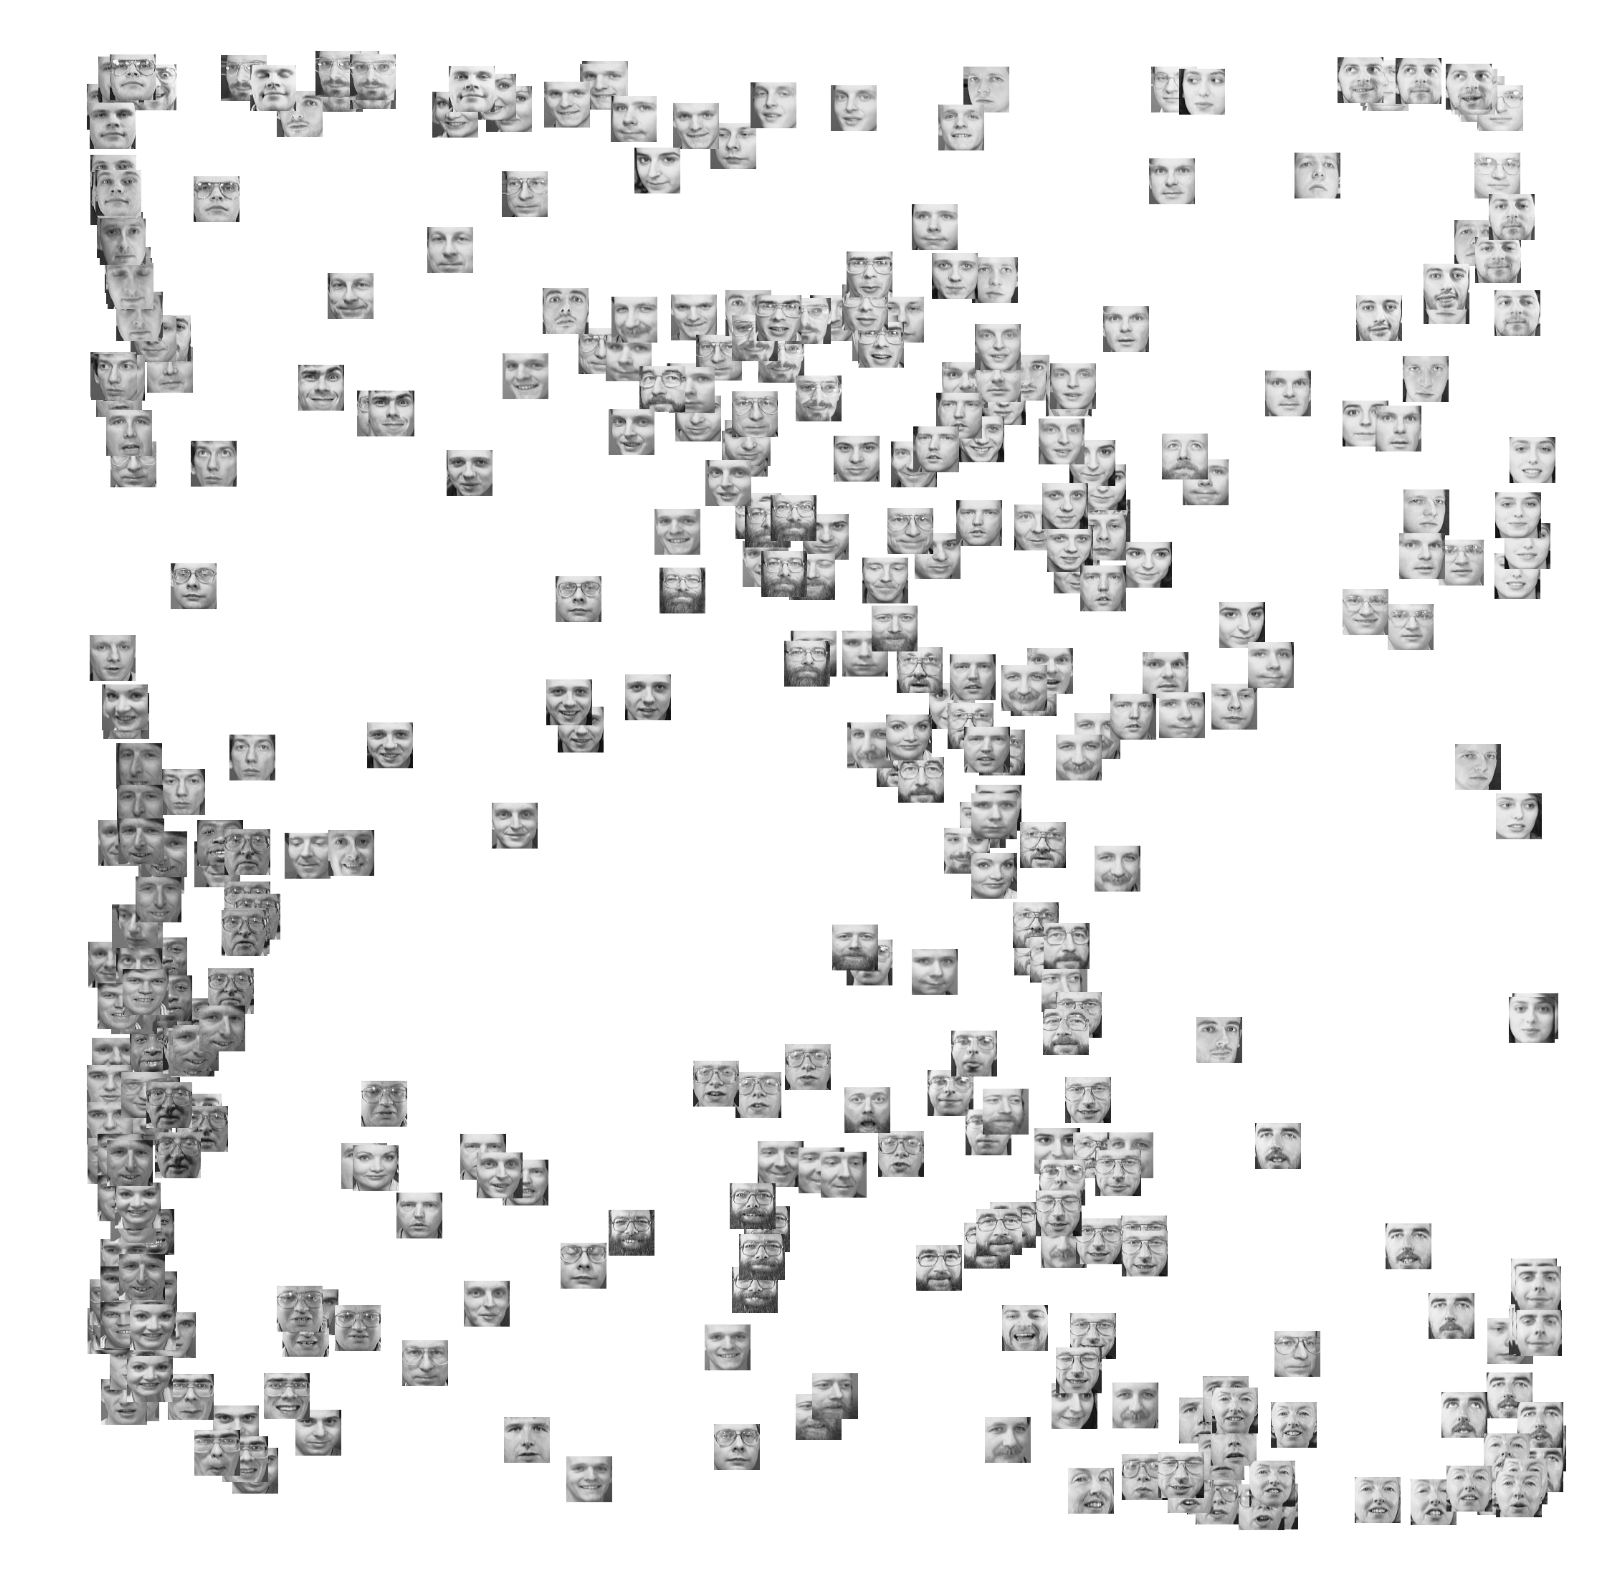

In [44]:
plot_dataset(X.reshape((400, 64, 64)), X_2d.data.numpy()[:, 0], X_2d.data.numpy()[:, 1])

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: